<a href="https://colab.research.google.com/github/schahor/TU_25_SS_Data-Mining-und-Maschinelles-Lernen-2025/blob/main/03_Loesung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importieren der benötigten Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (confusion_matrix, mean_absolute_error,
                             mean_squared_error, mean_squared_log_error,
                             median_absolute_error, precision_recall_curve,
                             r2_score, roc_auc_score, roc_curve)
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import GaussianNB


# Aufgabe 3.2 Precision, Recall und Accuracy

Wir verwenden hier das [Breast Cancer Wisconsin (Diagnostic) Data Set](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html). Die Merkmale werden aus einem digitalisierten Bild eines Feinnadelaspirats (FNA) einer Brustmasse berechnet. Sie beschreiben die Merkmale der im Bild vorhandenen Zellkerne.

In [ ]:
# Features im Dataset
datasets.load_breast_cancer().feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [ ]:
# Labels im Dataset
datasets.load_breast_cancer().target_names

array(['malignant', 'benign'], dtype='<U9')

In [ ]:
# Load Data
X, y = datasets.load_breast_cancer(return_X_y=True)
X_train, y_train = X[:int(0.8*len(X))], y[:int(0.8*len(y))]
X_test, y_test = X[int(0.8*len(X)):], y[int(0.8*len(y)):]

# Train classifier
clf = RandomForestClassifier(n_estimators=10, max_depth=1, random_state=42)
clf.fit(X_train, y_train)
y_scores = clf.predict_proba(X_test)

In [ ]:
y[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## f) PR-Kurve (Precision-Recall Kurve)
Die Optimierung auf Precision führt in der Regel zu einer Verringerung des Recalls und umgekehrt. Dies zeigt sich in einem PR-Kurvendiagramm wie im folgenden Beispiel, in dem wir einen RandomForestClassifier auf dem Brustkrebs-Datensatz ausführen. Die Datenpunkte für die PR-Kurve erhält man durch Berechnung der Precision und des Recall-Wertes für einen Satz von Schwellenwerten zwischen $0.0$ und $1.0$.

Implementieren Sie die Funktion _plot\_pr\_curve_.
Sie können dabei die Funktion [sklearn.metrics.precision_recall_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) verwenden.

In [ ]:
def plot_pr_curve(y: np.ndarray, y_scores: np.ndarray):
    """Zeichnet die Kurve für die Precision und den Recall für die wahren Klassenlabels y und die vorhergesagten Labels mit ihrer Wahrscheinlichkeit"""

    precision, recall, thresholds = precision_recall_curve(
        y_true=y, probas_pred=y_scores[:, 1]
    )

    # Plot PR Curve
    plt.figure()
    plt.plot(recall, precision, 'o-', label="Thresholds")
    for idx, theta in enumerate(thresholds):
      plt.annotate(f'{theta:.2f}', (recall[idx], precision[idx]))
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.tight_layout()
    plt.show()
    return thresholds

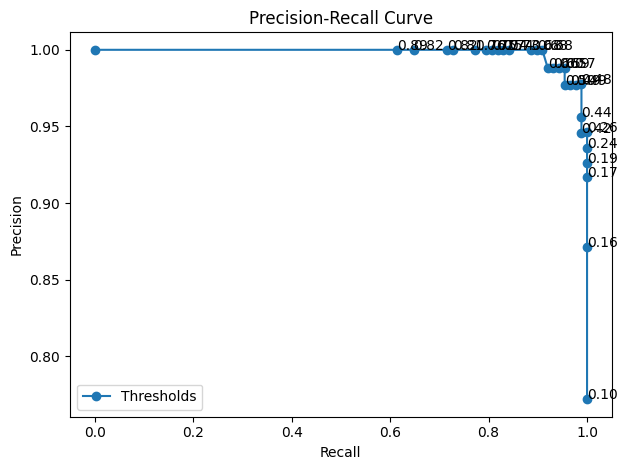

In [ ]:
thresholds = plot_pr_curve(y_test, y_scores)

In [ ]:
def plot_pr_curve_custom(y: np.ndarray, y_scores: np.ndarray, num_thresholds: int=10):
  '''Eigene Implementierung der PR-Kurve'''

  # Berechne maximalen Wert für obere Threshold Grenze
  max_score = y_scores[:, 1].max()
  thresholds = np.linspace(start=0.0, stop=max_score, num=num_thresholds)

  # Berechne Precision und Recall für alle Thresholds
  precision_list = []
  recall_list = []
  for theta in thresholds:
    pred = y_scores[:, 1] >= theta
    TP = np.logical_and(pred == 1, y==1).sum()
    FP = np.logical_and(pred == 1, y==0).sum()
    FN = np.logical_and(pred == 0, y==1).sum()
    precision = TP / (TP + FP + 1e-10)
    recall = TP / (TP + FN + 1e-10)
    precision_list.append(precision)
    recall_list.append(recall)

  # Plotte Ergebnisse
  plt.plot(recall_list, precision_list, 'o-', label="Thresholds")
  for idx, theta in enumerate(thresholds):
    plt.annotate(f'{theta:.2f}', (recall_list[idx], precision_list[idx]))
  plt.title("Precision-Recall Curve")
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.legend()
  plt.tight_layout()
  plt.show()

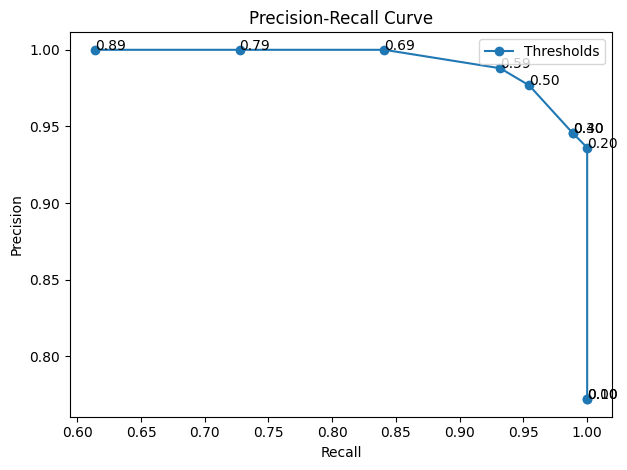

In [ ]:
plot_pr_curve_custom(y_test, y_scores)

## g) ROC-Kurve (Receiver Operating Characteristic)
Implementieren Sie die Funktion _plot\_roc\_curve_ um die ROC-Kurve zu visualisieren. Geben Sie im Plot-Titel den zugehörigen AUC-Wert an.
Sie können dabei die Funktionen [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) und [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) verwenden.


In [ ]:
y_pred = np.array([0.1, 0.5, 0.7])
y_pred >= 0.5

array([False,  True,  True])

In [ ]:
def plot_roc_curve(y, y_scores):
    """Zeichnet die Receiver-Operating-Characteristic-Kurve für die wahren Klassenlabels y und die vorhergesagten Labels mit ihrer Wahrscheinlichkeit"""

    # Berechne FPR und TPR
    fpr, tpr, thresholds = roc_curve(y_true=y, y_score=y_scores[:, 1])
    # Berechne Area under Curve
    auc = roc_auc_score(y, y_scores[:, 1])

    # Plotte ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, 'o-')
    plt.plot([0, 1], [0, 1], linestyle="--", c="r")
    plt.title(f"ROC Curve ($AUC={auc:.2f}$)")
    plt.xlabel("False Positives Rate")
    plt.ylabel("True Positives Rate")
    plt.show()

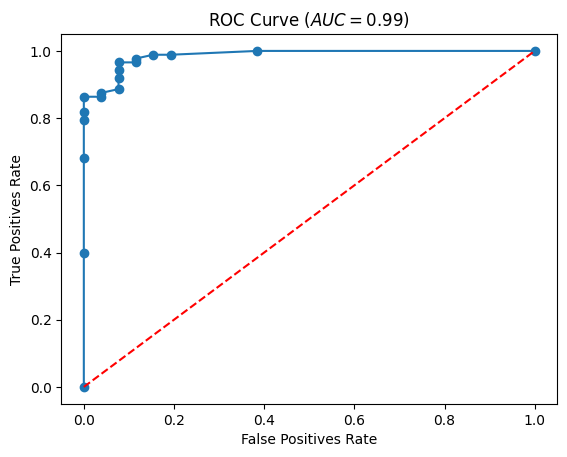

In [ ]:
plot_roc_curve(y_test, y_scores)

## h) Confusion Matrix

Zeigen Sie die Konfusionsmatrix über die Funktion _plot\_confusion\_matrix_ an.
Sie können dabei die Funktionen [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) und [seaborn.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) verwenden.


In [ ]:
def plot_confusion_matrix(y_test: np.ndarray, y_scores: np.ndarray, threshold: int):
    """Zeichnet die Konfusionsmatrix für die wahren Labels y und die vorhergesagten Labels y_pred"""
    # Get tpr and fpr values for all thresholds
    y_pred = y_scores[:, 1] >= threshold
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm)
    sns.heatmap(df_cm, annot=True, cmap=plt.cm.Greens)
    plt.title("Confusion matrix")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.grid(False)
    plt.show()

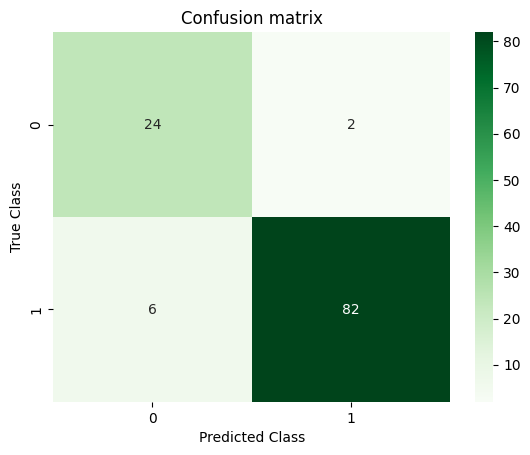

In [ ]:
plot_confusion_matrix(y_test, y_scores, 0.5)

# Aufgabe 3.3 Fehlermetriken der Regression

## a) Metrikevaluierung
Evaluieren Sie die oben beschriebenen Metriken in der Funktion _evaluate\_metric_.
Wenden Sie dabei zunächst eine 5-fache Kreuzvalidierung mittels [sklearn.model_selection.cross_val_predict.html](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) an und werten Sie anschließend die Metrik über die Parameterübergabe von _y\_true_ und _y\_pred_ aus.

Wir werden hierzu den [California Housing Prices Datensatz](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) verwenden. Die Daten enthalten Informationen aus der Volkszählung von 1990 in Kalifornien. Auch wenn sie Ihnen nicht bei der Vorhersage aktueller Immobilienpreise helfen können, bieten sie doch einen zugänglichen Einführungsdatensatz für die Vermittlung der Grundlagen des maschinellen Lernens.

Als Modell dient hierzu ein [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) Modell. Dieses konstruiert ein Ensemble von mehreren Regression Tree Modellen und liefert den Mittelwert der Vorhersagen der einzelnen Modelle.

In [ ]:
# Load boston house pricing dataset
X, y = datasets.fetch_california_housing(return_X_y=True)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [ ]:
print('Features:\t', datasets.fetch_california_housing().feature_names)
print('Target:\t\t', datasets.fetch_california_housing().target_names)

Features:	 ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target:		 ['MedHouseVal']


In [ ]:
# define regression model (Random Forest Regressor)
model = RandomForestRegressor(n_estimators=10)

In [ ]:
def evaluate_metric(X: np.ndarray, y: np.ndarray, clf: sklearn.base.BaseEstimator, metric:  staticmethod.__func__) -> float:
  """Führt eine 5-fold cross validation durch und evaluiert mithilfe der übergebenen Metrik."""
  # Predict every datapoint with cross validation
  y_pred = cross_val_predict(clf, X, y, cv=5, n_jobs=-1)
  # Evaluate metric
  err = metric(y_true=y, y_pred=y_pred)
  return err

In [ ]:
# define custom RMSE implementation (not available in sklearn)
def root_mean_squared_errror(y_true, y_pred):
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  return rmse

In [ ]:
# Evaluate predictions w.r.t. the above metrics
print(f"{'Metric':<24}{'Score':>6}")
print("-" * 30)

# define list of tuples containing the metric and its name
for metric, name in [
    (mean_absolute_error, "Mean Absolute Error"),
    (mean_squared_error, "Mean Squared Error"),
    (root_mean_squared_errror, "Root Mean Squared Error"),
    (mean_squared_log_error, "Mean Log Squared Error"),
    (median_absolute_error, "Median Absolute Error"),
    (r2_score, "R2 Score")]:

    # evaluate with metric
    err = evaluate_metric(X, y, model, metric)

    # print out results (formatted)
    print(f"{name:<24}{err: >6.2f}")

Metric                   Score
------------------------------
Mean Absolute Error       0.49
Mean Squared Error        0.47
Root Mean Squared Error   0.46
Mean Log Squared Error    0.04
Median Absolute Error     0.34
R2 Score                  0.65
